<a href="https://colab.research.google.com/github/AbhilashBharadwaj/CSE546/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [304]:
import numpy as np
import time
import cv2
import gym
from gym import spaces
from google.colab import widgets
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [305]:
#Based on Professor Alina Vereshchaka's notebooks
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    ROWS = 9
    COLS = 9

    # Actions
    # UP, DOWN, LEFT, RIGHT, UP_LEFT, UP_RIGHT, DOWN_LEFT, DOWN_RIGHT

    NO_OF_ACTIONS = 8

    def remove_points(self,arr:np.ndarray, points:list):
          arr_list = list(arr)
          for i in range(len(points)):
             for j in range(len(arr)):
               if(all(list(arr[j]) == points[i])):
                 arr_list.pop(j)
          return np.asarray(arr_list)
  

    def set_artifact_positions(self,environment):
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([8, 8])
        self.demon_pos = np.asarray([4, 4])
        if(environment == 'deterministic' ):
          self.toxin_pos = np.asarray([[3,2], [7,6], [2,7]])
          self.hp_pos = np.asarray([[1,1], [3,4], [4,7]])
        else:
          self.toxin_pos = self.remove_points(np.random.randint(0, 8,size=(3,2)),[self.agent_pos, self.goal_pos, self.demon_pos])  # ensure no tilespace collision occurs
          self.hp_pos = self.remove_points(np.random.randint(0, 8,size=(3,2)),[self.agent_pos, self.goal_pos, self.demon_pos])
       



    def __init__(self, environment_type='deterministic'):
        self.environment_type = environment_type
        self.observation_space = spaces.Discrete(self.ROWS * self.COLS)
        self.action_space = spaces.Discrete(self.NO_OF_ACTIONS)
        self.max_timesteps = 500
        self.timesteps = 0

        # Create a map of coordinates and state
        self.coordinates_state_mapping = {}
        for i in range(self.ROWS):
            for j in range(self.COLS):
                self.coordinates_state_mapping[f'{np.asarray([j, i])}'] = i * self.COLS + j
                
    def reset(self):
        self.timestep = 0
        self.set_artifact_positions(self.environment_type)

        # return the agent_pos coordinates
        observation = self.coordinates_state_mapping[f'{self.agent_pos}']
        return observation

    def step(self, action):
      
        #Actions
        if action == 0:
          self.agent_pos[0] += 1 # Agent moves right
        elif action == 1:
          self.agent_pos[0] -= 1 # Agent moves left
        elif action == 2:
          self.agent_pos[1] += 1 # Agent moves up
        elif action == 3:
          self.agent_pos[1] -= 1 # Agent moves down
        elif action == 4:        # Agent moves down_right
          self.agent_pos[0] += 1 
          self.agent_pos[1] += 1
        elif action == 5:        # Agent moves top_left
          self.agent_pos[0] -= 1
          self.agent_pos[1] -= 1
        elif action == 6:        # Agent moves top_right
          self.agent_pos[0] += 1
          self.agent_pos[1] -= 1
        elif action == 7:        # Agent moves down_left
          self.agent_pos[0] -= 1  
          self.agent_pos[1] += 1  
            
           
        # Clipping
        self.agent_pos = np.clip(self.agent_pos, a_min=[0, 0],
                                 a_max=[self.ROWS - 1, self.COLS - 1])
      
        observation = self.coordinates_state_mapping[f'{np.asarray(self.agent_pos)}']


        #Reward assignment
        reward = 0
        toxin_reward = -3
        hp_reward = 3
        goal_reward = 100
        demon_reward = -100
        
              

        done = False

        # Render is called here to ensure tile-agent interaction visualisation is preserved
        # (Artifacts once popped out of the array will remove the "interaction" for visualisation logic to use)
        with output_grid.output_to(0, 0):
          output_grid.clear_cell()
          self.render()
       
       # Terminate if goal is attained
        if (self.agent_pos == self.goal_pos).all():
            reward += goal_reward
            done = True

       # Terminate if interacts with demon
        elif(self.agent_pos == self.demon_pos).all():
            reward += demon_reward 
            done = True   
      
        # if hp_pos is encountered, collect reward and pop the hp from hp_pos
        elif any(((hp_pos == self.agent_pos).all() for hp_pos in self.hp_pos)):      
          for i in range(len(self.hp_pos)):
              if (self.agent_pos == self.hp_pos[i]).all():
                reward += hp_reward
                self.hp_pos = self.remove_points(self.hp_pos,[self.hp_pos[i]]) 
                break 
                

        # if toxin_pos is encountered, collect reward and pop the hp from toxin_pos
        elif any(((toxin_pos == self.agent_pos).all() for toxin_pos in self.toxin_pos)):          
          for i in range(len(self.toxin_pos)):
              if (self.agent_pos == self.toxin_pos[i]).all():
                reward += toxin_reward
                self.toxin_pos = self.remove_points(self.toxin_pos,[self.toxin_pos[i]])      
                break
                  

        self.timestep += 1

        if (self.timestep >= self.max_timesteps):
          done = True

        info = {}
       

        return observation, reward, done, info

    # Nitin Kulkarni's render method modified for the context
    def render(self, mode='human', plot=False):
        """This method renders the environment.

        :param str mode: 'human' renders to the current display or terminal and returns nothing.
        :param bool plot: Boolean indicating whether we show a plot or not. If False, the method returns a resized NumPy
                     array representation of the environment to be used as the state. If True it plots the environment.

        :returns arr preprocessed_image: Grayscale NumPy array representation of the environment."""

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(0, 9)
        ax.set_ylim(0, 9)

        if(self.environment_type == "deterministic"):
          ax.set_title('Deteministic Learning Env')
        else:
          ax.set_title('Stochastic Learning Env') 

        def plot_image(plot_pos):
            """This is a helper function to render the environment. It checks which objects are in a particular
            position on the grid and renders the appropriate image.

            :param arr plot_pos: Co-ordinates of the grid position which needs to be rendered."""

            # Initially setting every object to not be plotted.
            plot_agent, plot_hp, plot_goal, plot_toxin, plot_demon = \
                False, False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if any(np.array_equal(self.hp_pos[i], plot_pos) for i in range(len(self.hp_pos))):
                plot_hp = True
        
            if any(np.array_equal(self.toxin_pos[i], plot_pos) for i in range(len(self.toxin_pos))):
                plot_toxin = True
       
            if np.array_equal(plot_pos, self.demon_pos):
                plot_demon = True

            if np.array_equal(plot_pos, self.goal_pos):
                plot_goal = True    

            # Plot for Agent.
            if plot_agent and \
                    all(not item for item in
                        [plot_hp, plot_goal, plot_toxin, plot_demon]):
                agent = AnnotationBbox(OffsetImage(plt.imread('./images/agent.png'), zoom=0.3),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

          
            # Plot for Toxin.
            elif plot_toxin and \
                    all(not item for item in
                        [plot_agent, plot_hp, plot_goal, plot_demon]):
                toxin = AnnotationBbox(OffsetImage(plt.imread('./images/toxin.png'), zoom=0.3),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(toxin)
           
            # Plot for HP.
            elif plot_hp and \
                    all(not item for item in
                        [plot_agent, plot_toxin, plot_goal, plot_demon]):
                hp = AnnotationBbox(OffsetImage(plt.imread('./images/hp.png'), zoom=0.3),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(hp)     

            # Plot for Demon.
            elif plot_demon and \
                    all(not item for item in
                        [plot_agent, plot_hp, plot_goal, plot_toxin]):
                demon = AnnotationBbox(OffsetImage(plt.imread('./images/demon.png'), zoom=0.3),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(demon)

            # Plot for Goal.
            elif plot_goal and \
                    all(not item for item in
                        [plot_agent, plot_hp, plot_demon, plot_toxin]):
                goal = AnnotationBbox(OffsetImage(plt.imread('./images/goal.png'), zoom=0.3),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(goal)    

            # Plot for Agent and HP.
            elif all( [plot_agent, plot_hp]) and \
                    not(all(
                        [plot_goal, plot_toxin, plot_demon])):
                agent_hp = AnnotationBbox(OffsetImage(plt.imread('./images/agent_hp.png'), zoom=0.3),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_hp)

            # Plot for Agent and Toxin.
            elif all(item for item in [plot_agent, plot_toxin]) and \
                    all(not item for item in
                        [plot_hp, plot_goal, plot_demon]):
                agent_toxin = AnnotationBbox(OffsetImage(plt.imread('./images/agent_toxin.png'), zoom=0.3),
                                           np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_toxin)


            # Plot for Agent and Demon.
            elif all(item for item in [plot_agent, plot_demon]) and \
                    all(not item for item in
                        [plot_goal, plot_toxin, plot_hp]):
                agent_demon = AnnotationBbox(OffsetImage(plt.imread('./images/agent_demon.png'),
                                                          zoom=0.3), np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_demon)

            # Plot for Agent and Goal.
            elif all(item for item in [plot_agent, plot_goal]) and \
                    all(not item for item in
                        [plot_demon, plot_toxin, plot_hp]):
                agent_goal = AnnotationBbox(OffsetImage(plt.imread('./images/agent_goal.png'),
                                                          zoom=0.3), np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_goal)    

         
        # Create a map of state and coordinates 
        state_coordinates_mapping = {}
        for j in range(self.ROWS * self.COLS):
            state_coordinates_mapping[j] = np.asarray(
                [j % self.COLS, int(np.floor(j / self.COLS))])

        # Rendering the images for all states.
        for position in state_coordinates_mapping:
            plot_image(state_coordinates_mapping[position])

        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
        plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
        plt.grid()  # Setting the plot to be of the type 'grid'.

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84
            height = 84
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image

In [306]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, observation):
    return np.random.choice(self.action_space.n)

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

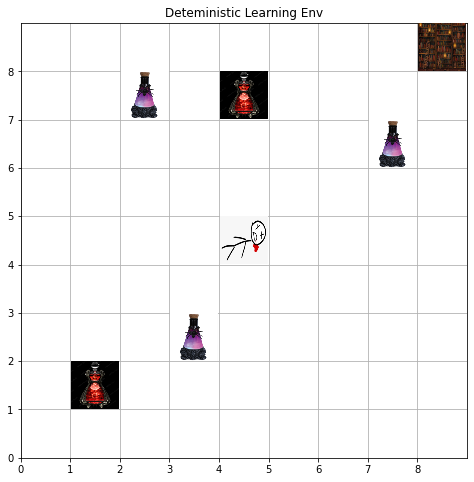

<IPython.core.display.Javascript object>

In [307]:
env = GridEnvironment()
agent = RandomAgent(env)

obs = env.reset()
done = False

output_grid = widgets.Grid(1,1)
with output_grid.output_to(0, 0):
  env.render()

while not done:
  action = agent.step(obs)
  obs, reward, done, info = env.step(action)
  time.sleep(0.4)